<center><h1>Tensorflow and CNN</h1></center>

- This exercise is a variation of an exercise from [Udacity Tensorflow Free Course](https://classroom.udacity.com/courses/ud187). 


<a target="_blank" href="https://colab.research.google.com/github/PrzemekSekula/DeepLearningClasses1/blob/master/CNN/CNN.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>

# Initial actions

In [1]:
!pip install -U tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.8.3
    Uninstalling tensorflow-datasets-4.8.3:
      Successfully uninstalled tensorflow-datasets-4.8.3


In [1]:
# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


For this exercises we are using  the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28  ×  28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc) in an identical format to the articles of clothing we'll use here.


In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Trousers</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td> 
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [3]:
class_names = ['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [4]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


## Preprocess the data
The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [5]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

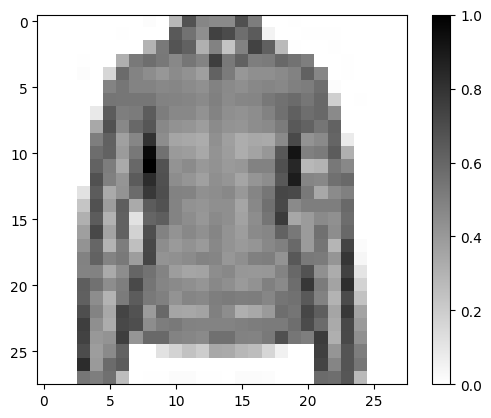

In [7]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

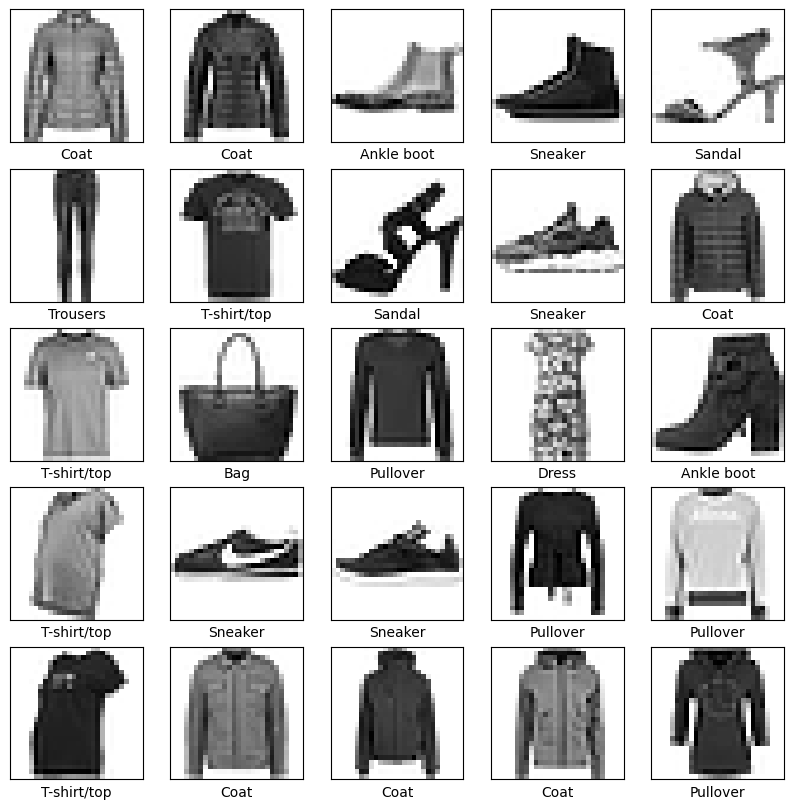

In [8]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

# TO DO

## Task 1 - Build a model
Build a fully connected (dense) neural network with one hidden layer that contains 128 neurons. Your network should contain three layers:

* **input** `tf.keras.layers.Flatten` — This layer transforms the images from a 2d-array of 28 $\times$ 28 pixels, to a 1d-array of 784 pixels (28\*28). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn, as it only reformats the data.

* **"hidden"** `tf.keras.layers.Dense`— A densely connected layer of 128 neurons. Each neuron (or node) takes input from all 784 nodes in the previous layer, weighting that input according to hidden parameters which will be learned during training, and outputs a single value to the next layer. Use *relu* activation function.

* **output** `tf.keras.layers.Dense` — A 10-node *softmax* layer, with each node representing a class of clothing. As in the previous layer, each node takes input from the 128 nodes in the layer before it. Each node weights the input according to learned parameters, and then outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

In [9]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Flatten(input_shape = (28,28,1)))
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

## Task 2 - Compile a model

Compile your model using the following parameters:
- **optimizer** `adam` - you may leave learning rate as default
- **loss function**  `sparse_categorical_crossentropy` - for multi-class classification
- **metrics** `accuracy` - for displaying accuracy during training process

In [10]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

## Task 3 - Prepare for training


First, we set the hyparparameters:
- Size of the batch: 32
- Number of epochs: 5


In [11]:
BATCH_SIZE = 32 
EPOCHS = 5 

Then we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(BATH_SIZE)` tells `model.fit` to use batches of `BATH_SIZE` images and labels when updating the model variables.

**Although for this task you have to set the `BATH_SIZE` and `EPOCHS` only, please try to understand what's going on here**



In [12]:
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Train the model

In [13]:
model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 19s 6ms/step - loss: 0.5034 - accuracy: 0.8217
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3734 - accuracy: 0.8672
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3345 - accuracy: 0.8779
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3103 - accuracy: 0.8858
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2906 - accuracy: 0.8936


## Task 4 - Test accuracy
Test the accuracy on train and test dataset. Use `model.evaulate` Display results.

In [21]:
train_loss, train_acc = model.evaluate(train_dataset,
                                      steps= math.ceil(num_train_examples/BATCH_SIZE))

test_loss, test_acc = model.evaluate(test_dataset,
                                     steps=math.ceil(num_test_examples/BATCH_SIZE))


print("TRAIN ACCURACY: {:.2f}%".format(100*train_acc), "TRAIN LOSS :{:.2f}%".format(100*train_loss))
print("TEST ACCURACY: {:.2f}%".format(100*test_acc), "TEST LOSS:{:.2f}%".format(100*test_loss))


313/313 [==============================] - 2s 5ms/step - loss: 0.3516 - accuracy: 0.8711
TRAIN ACCURACY: 89.88% TRAIN LOSS :26.99%
TEST ACCURACY: 87.11% TEST LOSS:35.16%


## Task 5 - Build the CNN model and compile it

Build and compile the model with parameters as follows:
- **Convolutional layer** `tf.keras.layers.Conv2D` - Convolutional layer with:
    - 32 filters
    - 3x3 filter (kernel) size
    - same padding
    - relu activation function
    - remember that this is the first layer so it is necessary to define input shape (28, 28, 1)
- **Max Pooling layer** `tf.keras.layers.MaxPooling2D` - Max Pooling layer with:
    - 2x2 filter (pool) size
    - stride = 2
- **Convolutional layer** `tf.keras.layers.Conv2D` - Convolutional layer with:
    - 64 3x3 filters
    - same padding
    - relu activation function    
- **Max Pooling layer** `tf.keras.layers.MaxPooling2D` - Same as previous max pooling layer
- **Flatten layer** `tf.keras.layers.Flatten` - Layer used to flatten the tensor output from the previous layer (7x7x64) into vector (,3136)
- **Dense** `tf.keras.layers.Dense`— A densely connected layer of 128 neurons. Use *relu* activation function.
- **output** `tf.keras.layers.Dense` — A 10-node *softmax* layer, with each node representing a class of clothing. As in the previous layer, each node takes input from the 128 nodes in the layer before it. Each node weights the input according to learned parameters, and then outputs a value in the range `[0, 1]`, representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

In [14]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation ='relu', input_shape = (28,28,1)))
model.add(tf.keras.layers.MaxPooling2D((2,2),strides = 2))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPooling2D((2,2), strides = 2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))



In [15]:
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

## Task 6 - Train your model
Set all the necessary hyperparameters and train your model. You may use the same values as for the dense model.

In [17]:
BATCH_SIZE = 32 
EPOCHS = 5 



In [18]:
model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 95s 48ms/step - loss: 0.3895 - accuracy: 0.8605
Epoch 2/5
1875/1875 [==============================] - 98s 53ms/step - loss: 0.2554 - accuracy: 0.9065
Epoch 3/5
1875/1875 [==============================] - 94s 50ms/step - loss: 0.2151 - accuracy: 0.9217
Epoch 4/5
1875/1875 [==============================] - 101s 54ms/step - loss: 0.1828 - accuracy: 0.9314
Epoch 5/5
1875/1875 [==============================] - 97s 52ms/step - loss: 0.1547 - accuracy: 0.9434


## Task 7 - Test accuracy
Test the accuracy on train and test dataset. Use `model.evaulate`. Compare the results with the ones you got using fully connected (dense) nural network.

In [19]:
train_loss, train_acc = model.evaluate(train_dataset,
                                      steps= math.ceil(num_train_examples/BATCH_SIZE))

test_loss, test_acc = model.evaluate(test_dataset,
                                     steps=math.ceil(num_test_examples/BATCH_SIZE))


print("TRAIN ACCURACY: {:.2f}%".format(100*train_acc), "TRAIN LOSS :{:.2f}%".format(100*train_loss))
print("TEST ACCURACY: {:.2f}%".format(100*test_acc), "TEST LOSS:{:.2f}%".format(100*test_loss))

313/313 [==============================] - 6s 20ms/step - loss: 0.2383 - accuracy: 0.9204
TRAIN ACCURACY: 95.80% TRAIN LOSS :11.66%
TEST ACCURACY: 92.04% TEST LOSS:23.83%
